# Web scraping the Aggie

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of aricle URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [3]:
import numpy as np
import pandas as pd
import lxml.html as lx


In [4]:
import requests
import requests_cache

#cache your requests to be polite 
requests_cache.install_cache("mycache")

# 2. Delay your requests (if you have a lot of them, in a loop)
import time
time.sleep(1)

In [5]:
def extract_links(url, page = 1, internal = [1, [], []]):

    [cp,titles,sublinks] = internal
    
    if cp == 1:
        
        response = requests.get(url)
        response.raise_for_status()

        doc = response.text
        html = lx.fromstring(doc, base_url = url)
        html.make_links_absolute()

        page_quota = int(html.xpath("//a[@class = 'page-numbers']")[-1].text_content())
        if not isinstance(page,int):
            print("Invalid page quota. Please try an integer between 1 and", page_quota)
            return(None)
        if page > page_quota:
            print("Invalid page quota. Please try an integer between 1 and", page_quota)
            return(None)
        
        links = html.xpath("//h2/a")

        titles = [x.text_content().strip('\n\t') for x in links]
        sublinks = [l.attrib['href'] for l in links]
        
    else: 
        response = requests.get(url)
        response.raise_for_status()

        doc = response.text
        html = lx.fromstring(doc, base_url = url)
        html.make_links_absolute()

        links = html.xpath("//h2/a")

        titles.extend([l.text_content().strip('\n\t') for l in links])
        sublinks.extend([l.attrib['href'] for l in links])
        
    if page > cp:
        print(str(cp) + "/" + str(page) +" pages parsed.")
        cp=cp+1
        url2 = html.xpath("//a[@class = 'next page-numbers']/@href")[0] 
        extract_links(url=url2,page=page,internal=[cp,titles,sublinks])
    else:
        print(str(cp) + "/" + str(page) +" pages parsed.")
        
    result = sublinks
    resultdf = pd.DataFrame([pd.DataFrame({"titles": titles})['titles'], pd.DataFrame({"links":sublinks})['links']]).T
    return(result)

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

* If you are having trouble working with unicode characters see [the python 3 documentation](https://docs.python.org/3/howto/unicode.html).

In [6]:
def extract_text(url):

    response = requests.get(url)
    response.raise_for_status()

    doc = response.text
    html = lx.fromstring(doc, base_url = url)
    html.make_links_absolute()

    author = html.xpath("//a[@class = 'author-name author']")[0].text_content()
    title = html.xpath("//h1[@class='entry-title']")[0].text_content()
    #text = html.xpath("//div[@itemprop='articleBody']")[0].text_content()
    text = html.xpath("//p[position() < last()]")
    text = "".join([x.text_content() for x in text])
    
    product = {
        "author": author, 
        "text": text, 
        "title": title, 
        "url":url
    }

    return(product)

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [7]:
campus = extract_links(url = 'https://theaggie.org/campus/', page = 4)
city = extract_links(url = 'https://theaggie.org/city/', page = 4)

1/4 pages parsed.
2/4 pages parsed.
3/4 pages parsed.
4/4 pages parsed.
1/4 pages parsed.
2/4 pages parsed.
3/4 pages parsed.
4/4 pages parsed.


In [8]:
category = ['campus']*60 + ['city']*60
urls = campus.copy()
urls.extend(city)

In [9]:
info_bank = [extract_text(x) for x in urls]
authors = [" ".join((x['author'].split("—"))[:-1]) for x in info_bank]
titles = [x['title'] for x in info_bank]
texts = [x['text'] for x in info_bank]

In [10]:
articles = pd.DataFrame(columns = ["category","url","author","title","text"])
articles['category'] = category
articles['url'] = urls
articles['author'] = authors
articles['title'] = titles
articles['text'] = texts


In [11]:
articles.head(90).tail(3)

,category,url,author,title,text
87,city,https://theaggie.org/2018/02/11/education-bike...,Stella Tran,Education on bike safety for youth,"Davis Bike and Pedestrian Program, Safe Routes..."
88,city,https://theaggie.org/2018/02/11/parking-protec...,Dylan Svoboda,Parking-protected bike lanes coming to major S...,Bicycling advocates are wheelie excitedThe Cit...
89,city,https://theaggie.org/2018/02/09/new-affordable...,Genevieve Murphy-Skilling,New affordable housing and emergency service c...,Paul’s Place to accommodate displaced individu...


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

# Part 1


In [12]:
import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwd = stopwords.words("english")

In [13]:
from collections import Counter

In [14]:
import wordcloud
from textblob import TextBlob
from nltk.corpus import wordnet
from itertools import compress

In [15]:
from nltk.stem import WordNetLemmatizer
from itertools import compress
import string

In [17]:
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

## **Now for Campus**

In [22]:
text = (" ".join(texts[:60]))
blob = TextBlob(text)
new_text = " ".join(w for w in blob.words if w.lower() not in stopwd)
blob = TextBlob(new_text)

In [23]:
tags = [wordnet_pos(x[1]) for x in blob.pos_tags]

wordnet_lemmatizer = WordNetLemmatizer()

y = [wordnet_lemmatizer.lemmatize(x,pos=t) for x, t in zip(blob.words, tags)] 
punc = list(string.punctuation) + ['”', '“', '’', '—', "''", '...', '=']
z = []
for x in y:
    if x not in punc:
        z.append(x)

token_lemmatized = " ".join(z)
blob_new = TextBlob(token_lemmatized)

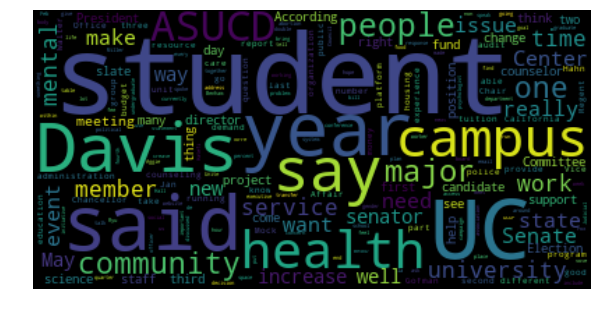

In [24]:
wordCloud(str(blob_new))

The campus news articles apear to make use of words like UC Davis, Davis, student, campus, health, ASUCD, university, and mental health. 

In [25]:
wdCounts = dict(blob_new.word_counts)
wcdf_campus = pd.DataFrame(columns=["word","freq"])#.head()
wcdf_campus.word,wcdf_campus.freq = (list(wdCounts.keys()),list(wdCounts.values()))

wcdf_campus.head()

,word,freq
0,guy-uriel,2
1,charles,17
2,speak,28
3,king,4
4,hallduke,1


## **Now for City**

In [26]:
text = (" ".join(texts[60:]))
blob = TextBlob(text)
new_text = " ".join(w for w in blob.words if w.lower() not in stopwd)
blob = TextBlob(new_text)

In [27]:
tags = [wordnet_pos(x[1]) for x in blob.pos_tags]

wordnet_lemmatizer = WordNetLemmatizer()

y = [wordnet_lemmatizer.lemmatize(x,pos=t) for x, t in zip(blob.words, tags)] 
punc = list(string.punctuation) + ['”', '“', '’', '—', "''", '...', '=']
z = []
for x in y:
    if x not in punc:
        z.append(x)

token_lemmatized = " ".join(z)
blob_new = TextBlob(token_lemmatized)

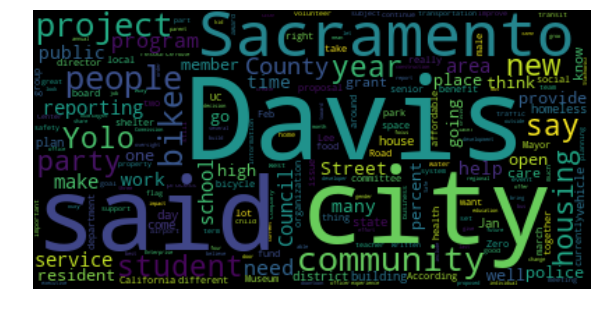

In [28]:
wordCloud(str(blob_new))

The city news articles make use of words like Sacramento, Davis, city, people, Yolo, County, community, and bike. 

In [29]:
wdCounts = dict(blob_new.word_counts)
wcdf_city = pd.DataFrame(columns=["word","freq"])
wcdf_city.word,wcdf_city.freq = (list(wdCounts.keys()),list(wdCounts.values()))

wcdf_city.head()

,word,freq
0,monica,2
1,feb,29
2,19,3
3,heard,8
4,last,15


In [30]:
wcdf_campus_ = wcdf_campus.sort_values(by="freq",ascending=False)
wcdf_campus_.reset_index(inplace=True,drop=True)
top200_campus = wcdf_campus_.head(200)

In [31]:
wcdf_city_ = wcdf_city.sort_values(by="freq",ascending=False)
wcdf_city_.reset_index(inplace=True,drop=True)
top200_city = wcdf_city_.head(200)

In [32]:
w = {}
for idx,row in top200_campus.iterrows():
    if row.word in list(top200_city.word):
        w.update({row.word:str((row.freq,top200_city.freq[idx]))})
df = pd.DataFrame(data=w,index=[0]).T.reset_index()[:-2]
df.columns = ["word","(campus.freq,city.freq)"]
df.tail()

,word,"(campus.freq,city.freq)"
94,way,"(73, 40)"
95,well,"(70, 36)"
96,work,"(113, 57)"
97,would,"(134, 66)"
98,year,"(108, 57)"


In [33]:
u = {}
for idx,row in top200_campus.iterrows():
    if row.word in list(top200_city.word):
        u.update({row.word: (float(row.freq) - int(top200_city.freq[idx]))})
df = pd.DataFrame(data=u,index=[0]).T.reset_index()[:-2]
df.columns = ["word","(campus.freq - city.freq)"]
df1 = df.copy()
df1 = df1.sort_values(by="(campus.freq - city.freq)",ascending=True)
df1.reset_index(inplace=True,drop=True)
df1.tail()

,word,(campus.freq - city.freq)
94,health,90.0
95,say,119.0
96,uc,130.0
97,davis,140.0
98,student,272.0


In [34]:
v = {}
for idx,row in top200_campus.iterrows():
    if row.word in list(top200_city.word):
        v.update({row.word: (float(row.freq) - int(top200_city.freq[idx])) / int(top200_city.freq[idx])})
df = pd.DataFrame(data=v,index=[0]).T.reset_index()[:-2]
df.columns = ["word","(campus.freq - city.freq) / city.freq"]
df2 = df.copy()
df2 = df2.sort_values(by="(campus.freq - city.freq) / city.freq",ascending=True)
df2.reset_index(inplace=True,drop=True)
df2.tail()

,word,(campus.freq - city.freq) / city.freq
94,students,1.000000
95,davis,1.029412
96,would,1.030303
97,health,1.097561
98,say,1.155340


In [35]:
import seaborn as sns

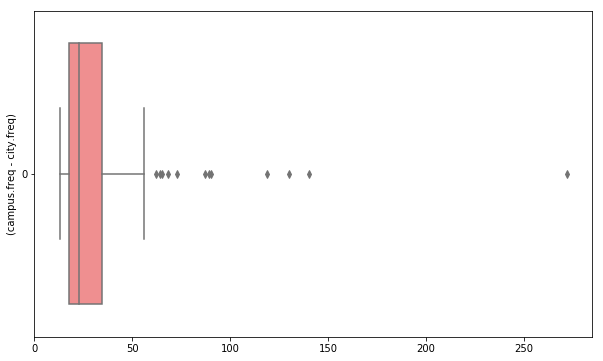

In [36]:
#Change asethetics slightly.
#Now graph these results
graph_zip = sns.boxplot(data = df1["(campus.freq - city.freq)"], palette = "spring_r",orient="horizontal")
plt.ylabel("(campus.freq - city.freq)")
plt.show()

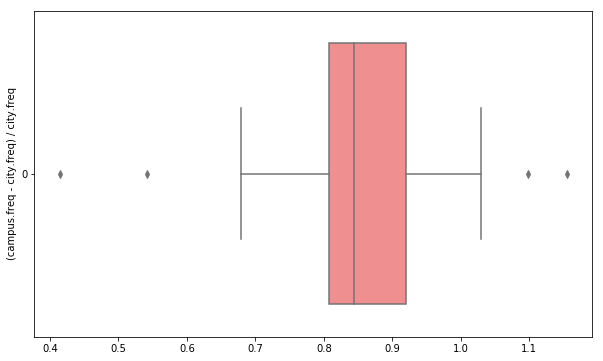

In [37]:
#Change asethetics slightly.
#Now graph these results
graph_zip = sns.boxplot(data = df2["(campus.freq - city.freq) / city.freq"], palette = "spring_r",orient="horizontal")
plt.ylabel("(campus.freq - city.freq) / city.freq")
plt.show()

Overall, there seems to be a lot of words that are somewhat frequent in both sets of articles. 2 of the most frequent 5 words in both article sets are "said" and "Davis."

# part 2

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
tf_idf = TfidfVectorizer().fit_transform(list(articles.title))

# Use .A to display a sparse matrix.
tf_iDF = pd.DataFrame(data = (tf_idf * tf_idf.T).A, columns = list(articles.title), index = list(articles.title))

In [42]:
test = pd.DataFrame({"title":list(articles.title),"max_tfidf": [list(set(sorted(x)))[-2] for x in (tf_idf * tf_idf.T).A]})

print(test.nlargest(n = 30, columns = "max_tfidf"))

     max_tfidf                                              title
9     1.000000  Sexual Violence Prevention and Response Board ...
77    1.000000                 Nishi 2.0 approved by City Council
4     1.000000  Executive ticket candidates claim biases again...
21    1.000000  2018 ASUCD Winter Elections — meet the candidates
23    1.000000  PERIOD holds pad and tampon drive, first infor...
42    1.000000                UC releases 150 year photo timeline
50    1.000000    UC Regents postpone tuition hike vote until May
65    1.000000        UC Davis student fighting for new city flag
82    1.000000         Revamping Sacramento International Airport
94    1.000000                           Women’s March Sacramento
40    1.000000  Sold-out Mental Health Conference featured key...
117   1.000000  Bike-share system to launch in Sacramento, Dav...
107   1.000000  Two new high-rise office buildings coming to S...
30    1.000000  Students for a Democratic Society meets with c...
115   0.56

In [43]:
tf_idf = TfidfVectorizer().fit_transform(list(articles.text))

# Use .A to display a sparse matrix.
tf_iDF = pd.DataFrame(data = (tf_idf * tf_idf.T).A, columns = list(articles.title), index = list(articles.title))

In [44]:
test = pd.DataFrame({"title":list(articles.title),"max_tfidf":[list(set(sorted(x)))[-1] for x in (tf_idf * tf_idf.T).A]})
quix = test.nlargest(n = 6, columns = "max_tfidf")

In [46]:
quix

,max_tfidf,title
16,0.549645,Adam Hatefi and Shreya Deshpande disqualified ...
51,0.549645,Judicial Council hearing held over prospective...
60,0.467928,Police Logs
67,0.467928,Police Logs
57,0.465283,Tapingo’s ties to private prison company Aramark
3,0.416460,UC Davis student protester arrested at Yiannop...


The three pairs of articles that share the highest portion of their corpus are #16 and #51, #60 and #67, and #57 and #3 in the table above. 

# part 3


In [16]:
text = (" ".join(texts))
blob = TextBlob(text)
new_text = " ".join(w for w in blob.words if w.lower() not in stopwd)
blob = TextBlob(new_text)

In [18]:
tags = [wordnet_pos(x[1]) for x in blob.pos_tags]

wordnet_lemmatizer = WordNetLemmatizer()

y = [wordnet_lemmatizer.lemmatize(x,pos=t) for x, t in zip(blob.words, tags)] 
punc = list(string.punctuation) + ['”', '“', '’', '—', "''", '...', '=']
z = []
for x in y:
    if x not in punc:
        z.append(x)

token_lemmatized = " ".join(z)
blob_new = TextBlob(token_lemmatized)

In [19]:
wdCounts = dict(blob_new.word_counts)
wcdf = pd.DataFrame(columns=["word","freq"])
wcdf.word,wcdf.freq = (list(wdCounts.keys()),list(wdCounts.values()))

wcdf.head()

,word,freq
0,guy-uriel,2
1,charles,17
2,speak,33
3,king,4
4,hallduke,1


In [20]:
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
def wordCloud(text):
    wordcloud = WordCloud(collocations = False).generate(text)
    plt.axis("off")
    return plt.imshow(wordcloud, interpolation='bilinear')

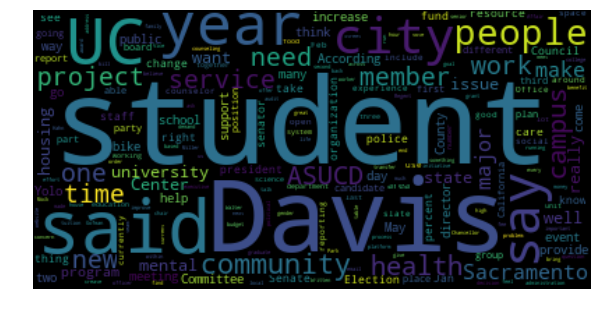

In [21]:
wordCloud(str(blob_new))

UC, Davis, and Student are each common words, and my guess is that they tend to show up often in that order. Other ones are common naration words: "say," "said." I think this corpus is representative of the Aggie. It's a University Newspaper with lots of stories about things that concern the student body. Therefore, all articles probably have a high potential to contain things about campus, the city of davis, and bikes (this is Davis we are talking about). 